In [1]:
import wisps
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import Normalize
import astropy.units as u 
import wisps.simulations.effective_numbers as eff
import seaborn as sns
import matplotlib
import itertools


%matplotlib inline

In [2]:
sgrid=wispsim.SPGRID
pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
corr_pols=wisps.POLYNOMIAL_RELATIONS['mag_limit_corrections'] 
klf=pd.read_csv('/users/caganze/research/wisps/data/kirkpatricklf.txt', delimiter=',')
klf['bin_center']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)
klf=klf.replace(0.0,np.nan)

cands=pd.read_pickle(wisps.LIBRARIES+'/real_ucds.pkl')
cands=cands[(cands.spt >=17) & (cands.snr1>=3)].reset_index(drop=True)
tab=wisps.Annotator.reformat_table(cands)
pnt_names=[x.name for x in pnts]

In [3]:
#cmap= sns.color_palette("coolwarm", 8, as_cmap=True)
cmap=matplotlib.cm.get_cmap('coolwarm')
cnorm=Normalize(wispsim.HS[0]/100, (wispsim.HS[-1])/100)

In [4]:
def bin_by_spt_bin(sp_types, number, ltonly=False):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    if ltonly:
        ranges=[[17, 20], [20, 30], [30, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

def get_all_numbers():
    #Distribute the parameter sets evenly across the cores
    func=lambda x, y:  get_simulated_number_model(y, x)

    paramlist=[(i, j)  for i, j in itertools.product(['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020'], wispsim.HS)]
    res  = [func(x, y) for x,y in tqdm(paramlist)]
    
    nbrs = {}
    for k in ['saumon2008', 'marley2019', 'phillips2020', 'baraffe2003']:
        ds0={}
        for j in res:
            if k in j.keys():
                key=[x for x in j[k].keys()][0]
                ds0.update({key: [(j[k][key])[yi] for yi in wispsim.SPGRID]})
        nbrs[k]=np.vstack([ds0[k] for k in wispsim.HS])

    return nbrs
    


def get_pointing(grism_id):
    if grism_id.startswith('par'):
        pntname=grism_id.lower().split('-')[0]
    else:
        pntname=grism_id.lower().split('-g141')[0]
    loc=pnt_names.index(pntname)
    return np.array(pnts)[loc]


def iswithin_mag_limits(mags, pnt, spt):
    #mgs is a dictionary
    flags=[]
    for k in pnt.mag_limits.keys():
        if k =='F110' and pnt.survey =='hst3d':
            flags.append(True)
        else:
            flags.append(mags[k] < pnt.mag_limits[k]+ (corr_pols['F110W'][0])(spt))
    return np.logical_or.reduce(flags)

def scale_lf_teff(teffs):
    binedges= np.append(klf['bin_center'].values, klf['bin_center'].values[-1]-150)
    preds=np.histogram(teffs, bins=np.flip(binedges)+75)[0]
    obs=np.array(klf['lf'])
    unc=np.array(klf['lfunc'])
    scale=np.nansum((obs*preds)/(unc**2)/((preds**2)/(unc**2)))/len(klf['bin_center'].values)
    fig, ax=plt.subplots()
    ax.step(klf['bin_center'], np.flip(preds*scale))
    ax.errorbar(klf['bin_center'], obs, yerr=unc, fmt='k')
    return scale

def get_simulated_number_model(hidx, model):
    #hidx is a scale height, model is evolutionary model
    cutdf=pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample_cut.h5', key=str(model)+str('h')+str(hidx)+'F110_corrected')
    scale=scale_lf_teff(cutdf.teff.values)*(10**-3)
    NSIM=dict(zip(wispsim.SPGRID,np.zeros(len(wispsim.SPGRID))))
    #rounded spectral type
    cutdf['spt_r']=cutdf.spt.apply(np.round)
    for g in cutdf.groupby('spt_r'):
        NSIM[g[0]]=np.nansum((g[1]).slprob*scale)
        
    return {model: {hidx:NSIM}}


def plot(NUMBERS, VOLUMES, filename='/oberved_numbers.pdf'):
    # In[ ]:
    nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
    
    y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)
    yall=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)
    
    dy2=np.sqrt(y2)
    dyall=np.sqrt(yall)

    fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharey=True, sharex=False)
    
    for model, a in zip(['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020'], np.concatenate(ax)):
        
        for idx, h in enumerate(wispsim.HS):
            
            ns=None
            ns=((NUMBERS[model])[idx])*VOLUMES[idx]
            
            a.step(spgrid2, bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False), 
                         where='mid', label='h={} pc'.format(h), color= cmap(cnorm(h/100)), linewidth=3)
        
        a.set_yscale('log')
        a.errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='k')
        a.errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', fmt='o', label='All observations')
    
        a.set_xlabel('SpT',fontsize=18)
        a.set_ylabel('N',fontsize=18)
        a.minorticks_on()
            


    ax[0][0].set_title('Model= SM08', fontsize=18)
    ax[0][1].set_title('Model= B03', fontsize=18)
    ax[1][0].set_title('Model= M19', fontsize=18)
    ax[1][1].set_title('Model= P20', fontsize=18)

    ax[0][0].errorbar(spgrid2,y2, yerr=dy2,fmt='o', color='k', label='observations')
    ax[0][0].errorbar(spgrid2,yall, yerr=dyall,color='#B10DC9', fmt='o', label='All observations')
    
    ax[0][0].legend(fontsize=14, loc='upper right')
    plt.tight_layout()
    plt.savefig(wisps.OUTPUT_FIGURES+filename, bbox_inches='tight')

In [5]:
tab['pnt']=tab['grism_id'].apply(get_pointing)
tab['spt_val']=np.vstack(tab.spt.values)[:,0]
obsmgs=tab[['F140W', 'F110W', 'F160W']].rename(columns={"F110W": "F110", 
                                                                    "F140W": "F140",
                                                                    "F160W": "F160"}).to_dict('records')

flags=[iswithin_mag_limits(x, y, z) for x, y, z in zip(obsmgs, tab.pnt.values,tab.spt.values )]

#let's see what happens if we include all objects
#flags=np.ones(len(flags)).astype(bool)
cdf_to_use=tab[flags]

nobs=wisps.custom_histogram(cdf_to_use.spt_val.apply(wisps.make_spt_number), sgrid, 1)

spgrid2=['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']
spgrid3=['Late M', 'L', 'T']

In [6]:
for k in ['F140', 'F110', 'F160']:
    tab['lim_{}'.format(k)]=tab.pnt.apply(lambda x: x.mag_limits[k])
    tab['detected_{}'.format(k)]= tab[k+'W'] < tab['lim_{}'.format(k)]

In [7]:
subtab=(tab[tab.spt.between(30, 35)]).reset_index(drop=True)

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print( subtab[['F140W', 'F160W', 'lim_F140', 'lim_F160', 'detected_F140', 'detected_F160', 'grism_id',
                  'spt']])

       F140W      F160W   lim_F140   lim_F160  detected_F140  detected_F160  \
0        NaN  23.067000  21.270535  21.398818          False          False   
1        NaN  24.397000  21.391264  21.419549          False          False   
2        NaN  23.925000  20.769205  21.308375          False          False   
3  23.843977  23.775902  22.707454  22.572660          False          False   
4        NaN  24.285000  20.860451  21.293626          False          False   
5        NaN  22.726000  21.056935  21.389148          False          False   
6  22.552442  22.941506  22.871843  22.773354           True          False   
7  22.706065  23.116423  22.890299  22.788902           True          False   

               grism_id   spt  
0          par191-00077  30.0  
1          par468-00163  31.0  
2          par467-00135  31.0  
3  cosmos-23-G141_10232  31.0  
4          par463-00176  34.0  
5          par130-00092  34.0  
6  goodss-04-G141_17402  34.0  
7   aegis-03-G141_17053  35.0  


In [9]:
p=(tab[tab.grism_id.isin(['par468-00163'])]).pnt.values[0]

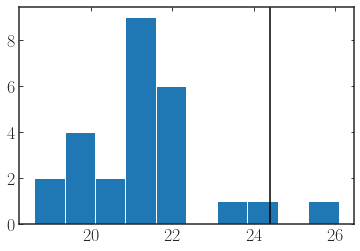

In [10]:
plt.hist(np.vstack([np.array(x) for x in p.mags['F160']])[:,0])
plt.axvline((tab[tab.grism_id.isin(['par468-00163'])]).F160W.values[0], C='k')

100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


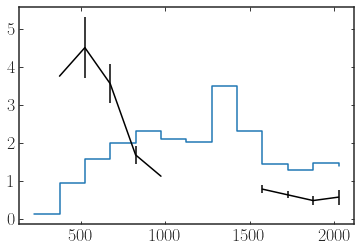

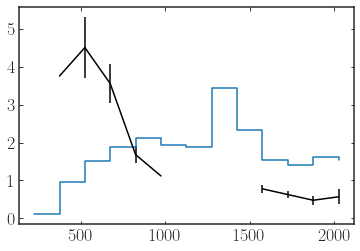

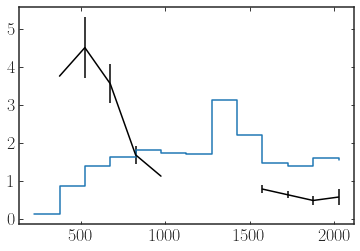

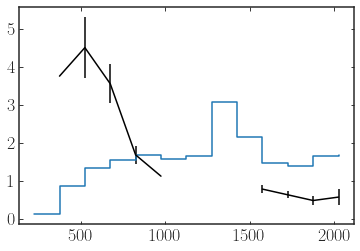

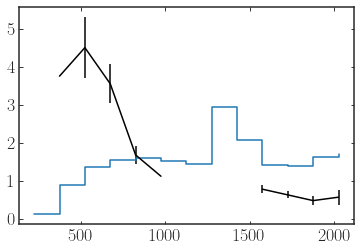

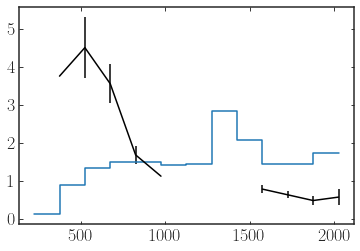

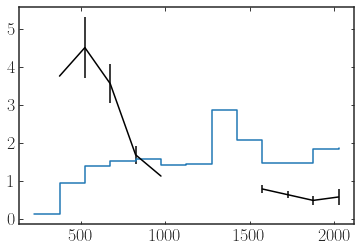

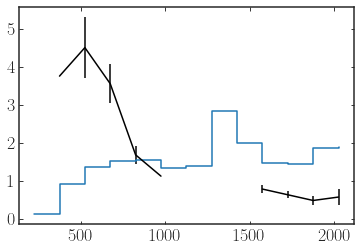

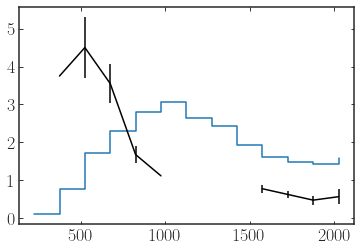

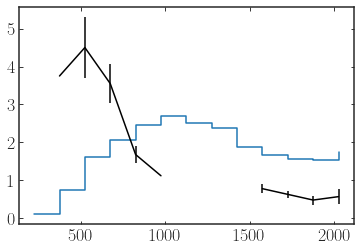

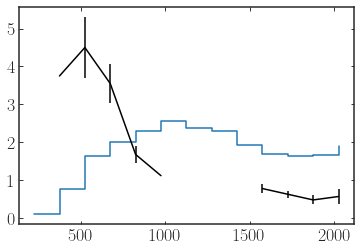

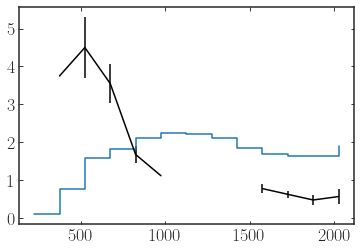

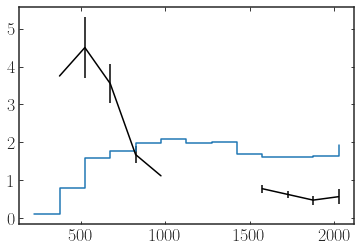

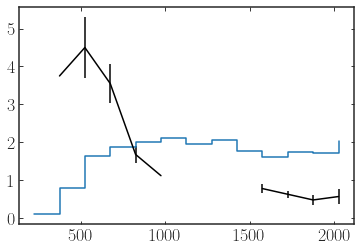

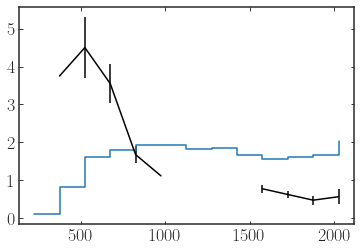

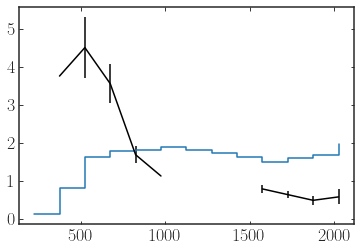

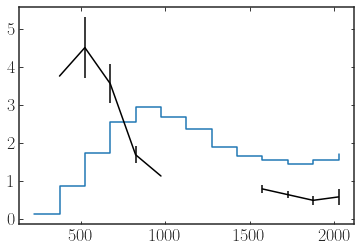

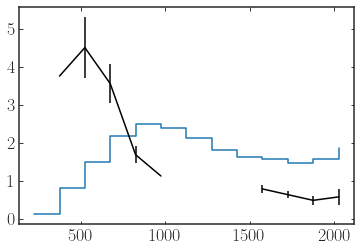

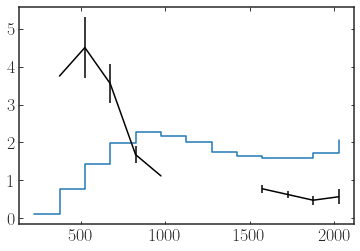

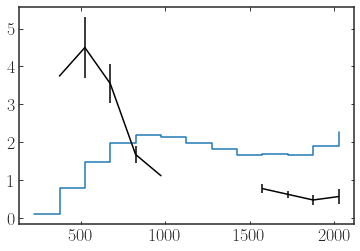

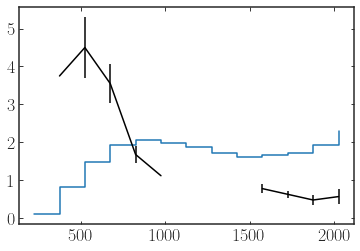

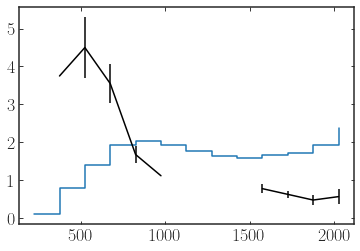

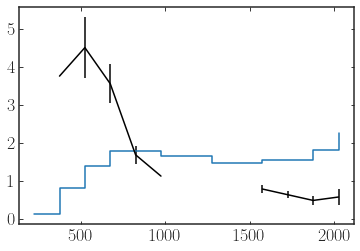

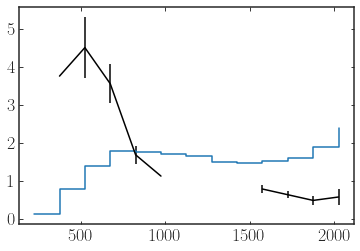

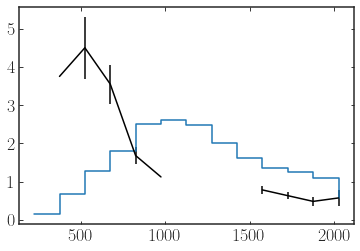

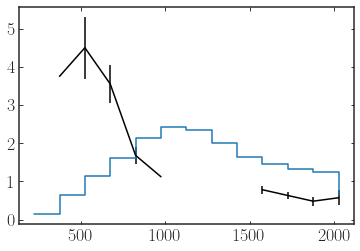

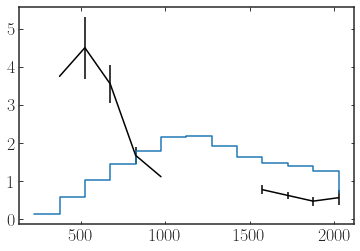

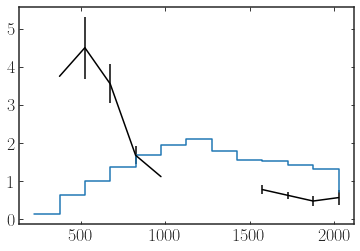

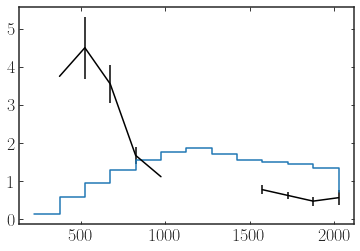

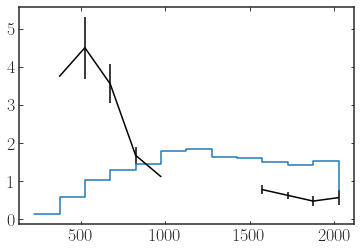

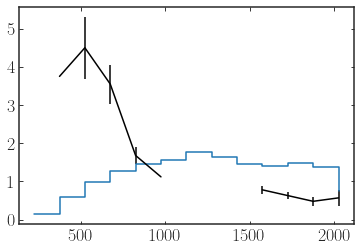

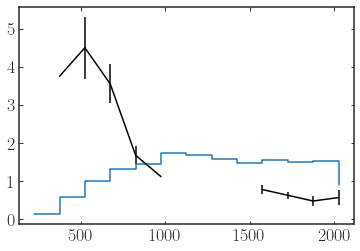

In [11]:
#NUMBERS=pd.read_pickle(wisps.OUTPUT_FILES+'/numbers_simulated.pkl')
NUMBERS=get_all_numbers()

In [12]:
volumes=[]
for pnt in pnts:
    vs=[]
    for h in wispsim.HS:
        vsx=[]
        for g in wispsim.SPGRID:
            vsx.append((pnt.volumes[h])[g])
        vs.append(vsx)
    volumes.append(vs)
volumes=np.array(volumes)

VOLUMES=np.nansum(volumes, axis=0)*4.1*(u.arcmin**2).to(u.radian**2)

In [13]:
#tab

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


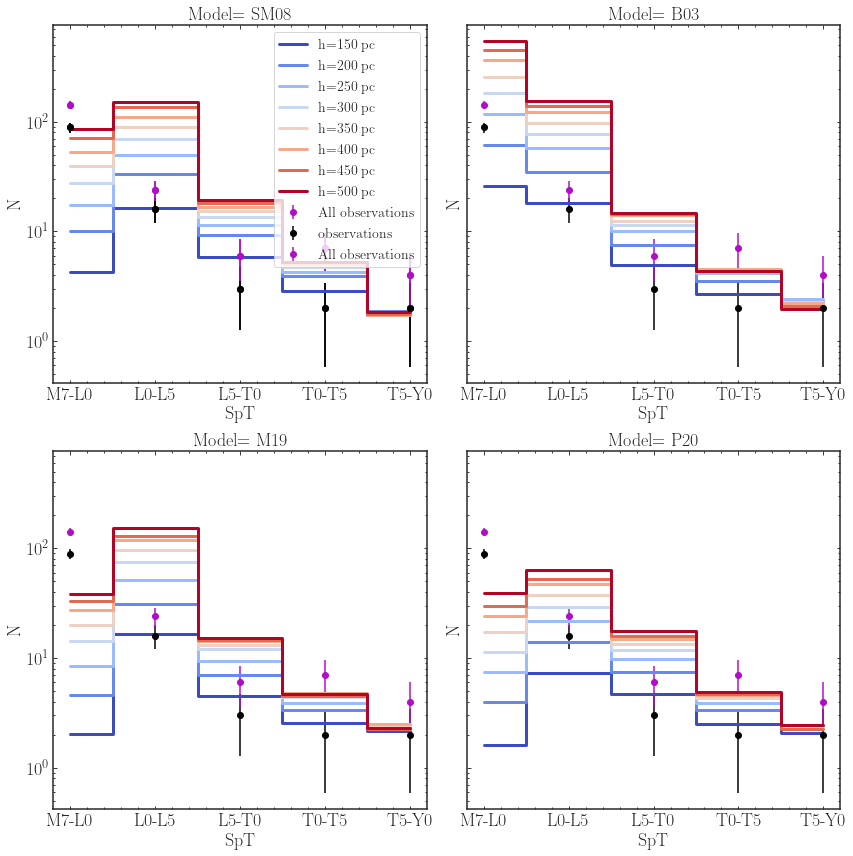

In [14]:
 plot(NUMBERS, VOLUMES, filename='/obs_numbers_F110.pdf')

In [15]:
nall=wisps.custom_histogram(cands.spt.apply(wisps.make_spt_number), sgrid, 1)
y2=bin_by_spt_bin(wispsim.SPGRID,nobs, ltonly=False)

In [16]:
y2

[89, 16, 3, 2, 2]

In [17]:
#bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)

In [18]:
#just for L dwarfs and T dwarfs
y3=bin_by_spt_bin(wispsim.SPGRID,nall, ltonly=False)

In [19]:
y3

[142, 24, 6, 7, 4]

In [20]:
y4=np.append(y2, y3)

In [21]:
#PRINT THE BEST FIT NUMBER 
#best_fit={}
numbers_fit={}
for model in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
        model_fit={}
        model_number={}
        for idx, h in enumerate(wispsim.HS):
            ns=None
            ns=np.array(((NUMBERS[model])[idx])*VOLUMES[idx])
            
            binned=np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False))
            
            binned_lt=np.array(bin_by_spt_bin(wispsim.SPGRID,ns, ltonly=False))
            #add L and 
            #compute chi-squared
            #print (ns)
            #chisq= abs((y2-binned)**2/(y2))
            #model_fit.update({h: chisq})
            binned_total=np.append(binned, binned_lt)
            model_number.update({h: binned_total})
        # best_fit.update({model: model_fit})
        numbers_fit.update({model: model_number})

In [22]:
#chisq_dicts=pd.DataFrame.from_records(best_fit)
number_dicts=pd.DataFrame.from_records(numbers_fit)

In [23]:
from scipy.interpolate import interp1d

In [24]:
len(tab[tab.spt.between(30, 35)])

8

(array([1.6000e+01, 4.8800e+02, 5.1320e+03, 1.8239e+04, 3.5004e+04,
        2.8293e+04, 1.0114e+04, 2.4460e+03, 2.5600e+02, 1.2000e+01]),
 array([ 91. , 101.7, 112.4, 123.1, 133.8, 144.5, 155.2, 165.9, 176.6,
        187.3, 198. ]),
 <BarContainer object of 10 artists>)

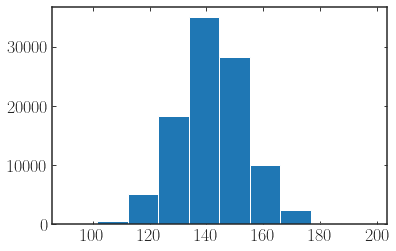

In [25]:
plt.hist(np.random.poisson(y3[0], 100000).astype(float))

[ 18.09702462  35.21167664  57.44738382  77.57745217  97.63748149
 123.92151106 139.68549657 154.59829562]
[ 16.50364906  31.36340012  51.32501845  75.45100752  96.58685652
 118.92901838 130.14049425 153.65873044]
[ 7.27455482 14.15038918 21.99483162 29.41482666 37.65085718 47.409492
 52.9217171  63.06348824]
[ 16.5124045   33.15763306  49.85268989  70.06008415  89.88560599
 111.10406985 137.55371564 152.88028718]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


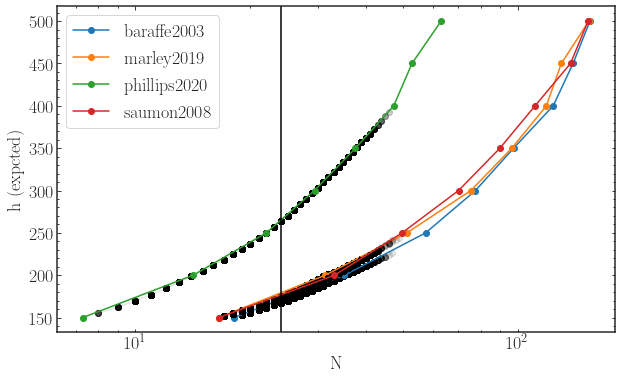

In [26]:
fig, ax=plt.subplots(figsize=(10, 6))
idx=1
for c in number_dicts.columns:
    
    vals=np.vstack([number_dicts[c][h] for h in wispsim.HS])[:,idx]
    print (vals)

    interpf = interp1d(vals, wispsim.HS)
    npoisson=np.random.poisson(y3[idx], 100000).astype(float)
    bflag=np.logical_and(npoisson>=vals.min(), npoisson <=vals.max())
    
    predhs=interpf(npoisson[bflag])
    sortarray=np.argsort(npoisson[bflag])
    plt.plot(  (npoisson[bflag])[sortarray], predhs[sortarray],'o-', c='k', alpha=0.1)
    plt.plot(vals, wispsim.HS, 'o-', label=c)
plt.ylabel('h (expcted)', fontsize=18)
plt.xlabel('N', fontsize=18)
plt.xscale('log')
plt.axvline(y3[idx], c='k')
plt.legend()
plt.minorticks_on()

In [27]:
number_dicts['marley2019'][500]

array([ 38.80947828, 153.65873044,  15.25842089,   4.65818514,
         2.29927228,  38.80947828, 153.65873044,  15.25842089,
         4.65818514,   2.29927228])

In [28]:
min_chi_ssqrs={}
for c in number_dicts.columns:
    min_vals={}
    #for idx,s  in enumerate(np.append(spgrid2, ['L dwarfs', 'T dwarfs'])):
    for idx,s  in enumerate(spgrid2):
        #compare between subtypes
        #predicted
        vals=(np.vstack(number_dicts[c].values))[:,idx]
        #observed
        nreal= y2[idx]
        #make an interpolation function
        interpf = interp1d(vals, wispsim.HS)
        #using a 2nd degree polynomial 
        #draw a bunch of random values based on a poisson distribution
        npoisson=np.random.poisson(nreal, 100000).astype(float)
        #stay within the range of possible values to avoid interpolation error
        #i.e take this as a prior
        npoisson=npoisson[np.logical_and(npoisson>=vals.min(), npoisson <=vals.max())]
        #predict scale heights
        predhs=interpf(npoisson)
        #use a weighted mean and std 
        mean, unc= (np.nanmean(predhs), np.nanstd(predhs))
    
        
        min_vals.update({s:[np.round(mean), np.round(unc, 4)]})
        #final minimal
        print (' scale height for model {} and spt {} is {} +/- {} '.format(c, s, np.round(mean), np.round(unc, 4)))
        
    min_chi_ssqrs.update({c:min_vals})
    

 scale height for model baraffe2003 and spt M7-L0 is 225.0 +/- 8.4221 
 scale height for model baraffe2003 and spt L0-L5 is 159.0 +/- 6.4662 
 scale height for model baraffe2003 and spt L5-T0 is 166.0 +/- 19.5718 
 scale height for model baraffe2003 and spt T0-T5 is 192.0 +/- 32.0754 
 scale height for model baraffe2003 and spt T5-Y0 is 484.0 +/- 0.0 
 scale height for model marley2019 and spt M7-L0 is nan +/- nan 
 scale height for model marley2019 and spt L0-L5 is 161.0 +/- 8.4514 
 scale height for model marley2019 and spt L5-T0 is 175.0 +/- 20.4843 
 scale height for model marley2019 and spt T0-T5 is 206.0 +/- 38.7348 
 scale height for model marley2019 and spt T5-Y0 is nan +/- nan 
 scale height for model phillips2020 and spt M7-L0 is nan +/- nan 
 scale height for model phillips2020 and spt L0-L5 is 212.0 +/- 25.9092 
 scale height for model phillips2020 and spt L5-T0 is 169.0 +/- 18.848 
 scale height for model phillips2020 and spt T0-T5 is 209.0 +/- 44.4317 
 scale height for m

In [29]:
pd.DataFrame(min_chi_ssqrs)

,baraffe2003,marley2019,phillips2020,saumon2008
M7-L0,"[225.0, 8.4221]","[nan, nan]","[nan, nan]","[477.0, 16.3583]"
L0-L5,"[159.0, 6.4662]","[161.0, 8.4514]","[212.0, 25.9092]","[159.0, 7.5371]"
L5-T0,"[166.0, 19.5718]","[175.0, 20.4843]","[169.0, 18.848]","[162.0, 13.9556]"
T0-T5,"[192.0, 32.0754]","[206.0, 38.7348]","[209.0, 44.4317]","[199.0, 71.0641]"
T5-Y0,"[484.0, 0.0]","[nan, nan]","[nan, nan]","[nan, nan]"


In [30]:
def propagate_uncertainties(row):
    vals=np.vstack(row.values)[:,0]
    uncs=np.vstack(row.values)[:,1]
    
    return round(np.nanmean(vals)), round(np.sqrt(np.nansum(uncs**2)+ np.nanstd(vals)**2))

In [31]:
pd.DataFrame(min_chi_ssqrs).apply(propagate_uncertainties, axis=1)

M7-L0    (351.0, 127.0)
L0-L5     (173.0, 37.0)
L5-T0     (168.0, 37.0)
T0-T5     (202.0, 98.0)
T5-Y0      (484.0, 0.0)
dtype: object

In [32]:
(376+227)/2

301.5

In [33]:
#use my velocity dispersion converter 
def velocity_dispersion(h, hunc):
    #do a monte carlo uncertainty prop
    hs= np.random.normal(h, hunc, 10000)
    vals=np.sqrt((hs*68)/217*20)

    return np.nanmean(vals), np.nanstd(vals)
    
vel_tables=pd.DataFrame(min_chi_ssqrs).apply(propagate_uncertainties, axis=1).apply(lambda x: velocity_dispersion(x[0], x[1]))

In [34]:
brfvls=pd.DataFrame(min_chi_ssqrs).baraffe2003.iloc[0]

In [35]:
#vel_tables['M7-L0']=velocity_dispersion(brfvls[0], brfvls[1])

In [36]:
#do monte carlo uncertainty propagation
def get_age(sigma, sigmaunc, beta, tau1, sigma10):
    sigmas=np.random.normal(sigma, sigmaunc, 10000)
    vals=((sigmas/sigma10)**(1/beta))*(10+tau1)-tau1
    return np.nanmean(vals), np.nanstd(vals)

In [37]:
age_tables= vel_tables.apply(lambda x: get_age(x[0], x[1], 0.385, 0.261, 57.157))
age_tables=age_tables.apply(lambda x:np.array(x)).apply(lambda x: np.round(x, 1))

In [38]:
age_emp=pd.DataFrame()
age_emp['subtype']=np.array(age_tables.index)
age_emp['age']=np.vstack(age_tables.values)[:,0]
age_emp['unc']=np.vstack(age_tables.values)[:,1]

In [39]:
vel_tables

M7-L0     (46.13079101191781, 8.866146578868005)
L0-L5     (32.66412227084167, 3.567652746536064)
L5-T0    (32.17931659336666, 3.6324062872413116)
T0-T5     (35.12041613380585, 8.698054464905402)
T5-Y0                  (55.075984378851906, 0.0)
dtype: object

In [40]:
age_emp

,subtype,age,unc
0,M7-L0,6.1,3.1
1,L0-L5,2.2,0.7
2,L5-T0,2.1,0.7
3,T0-T5,3.0,2.0
4,T5-Y0,9.1,0.0


In [41]:
def get_simpler_class(x):
    if x.startswith('M'):
        return 'Late M'
    if x.startswith('L'):
        return 'L'
    if x.startswith('T'):
        return 'T'

In [42]:
#plot age with scale heights
age_dictionaries={}
for model in ['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020']:
    dfs=[]
    for hidx in wispsim.HS:
        dfs.append(pd.read_hdf(wisps.OUTPUT_FILES+'/final_simulated_sample.h5', key=str(model)+str('h')+str(hidx)))
        
    df=pd.concat(dfs)
    print (len(df))
    cutdf_lblded=wisps.Annotator.group_by_spt(df, spt_label='spt', assign_number=False).rename(columns={'spt_range': 'subtype'})
    cutdf_lblded['spectclass']=  cutdf_lblded.subtype.apply(get_simpler_class)
    final_df=cutdf_lblded[~((cutdf_lblded.spectclass=='') | (cutdf_lblded.subtype=='')|   (cutdf_lblded.subtype=='trash'))]
    age_dictionaries[model]=final_df

1164252
1244645
1151895
457495


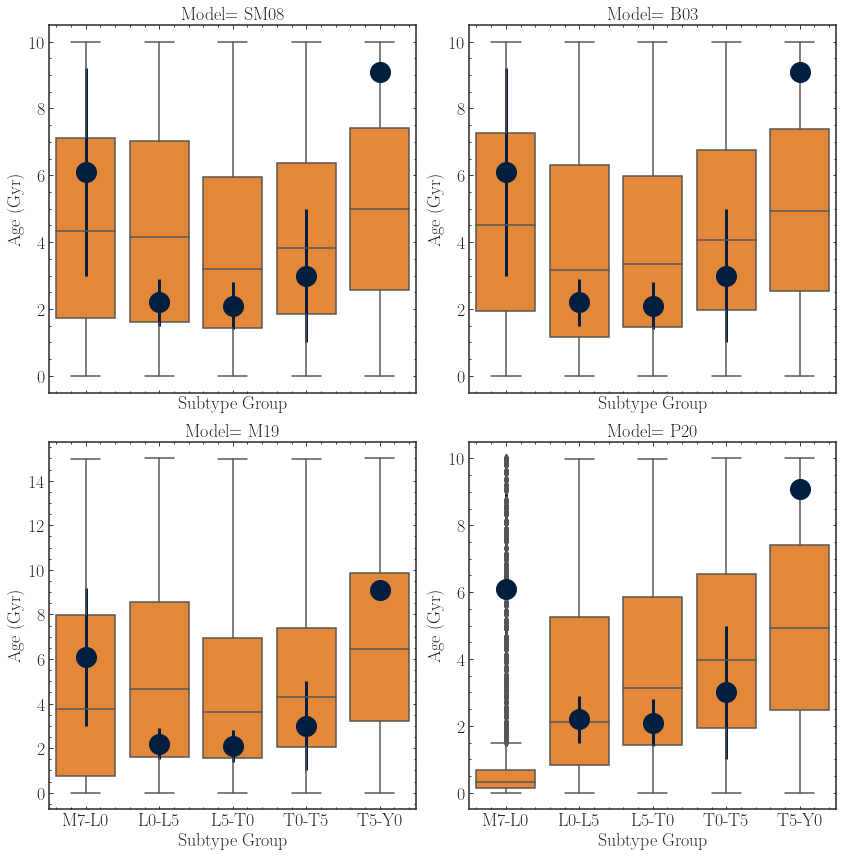

In [43]:

fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=2, sharex=True, sharey=False)

for model, a in zip(['saumon2008', 'baraffe2003', 'marley2019', 'phillips2020'], np.concatenate(ax)):
    
    dfn=age_dictionaries[model].replace('T5-T9', 'T5-Y0')
    #change T5-T9 to T5-Y0

    sns.boxplot(y=dfn.age.values, x=dfn.subtype, ax=a,
                color='#FF851B', order=spgrid2)
    
    #sns.boxplot(y=dfn.age.values*dfn.slprob, x=dfn.spectclass, ax=a,
    #            color='#FF851B')
    
    #upper and low limit of the error
    #lolims = np.array([0, 0, 0, 0,1], dtype=bool)
    lolims=np.array([0, 0, 0, 0, 0], dtype=bool)

    a.errorbar(age_emp.subtype,  age_emp.age, yerr=age_emp.unc, color='#001f3f', fmt='o',lolims=lolims, ms=20, lw=3)
    
    a.set_xlabel('Subtype Group', fontsize=18)
    a.set_ylabel('Age (Gyr)', fontsize=18)
    a.minorticks_on()

ax[0][0].set_title('Model= SM08', fontsize=18)
ax[0][1].set_title('Model= B03', fontsize=18)
ax[1][0].set_title('Model= M19', fontsize=18)
ax[1][1].set_title('Model= P20', fontsize=18)

plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/age_comparison_ltdwarfs_scled_chisq_lt.pdf', bbox_inches='tight')
